# 物体の衝突回数を数えて円周率を求める

水平な台の上に物体が2つあり、その片側に壁がある状況を考えます。壁から遠い方の物体 ($B_1$ と置く) を、もう一方の物体 ($B_q$ と置く) に目掛けて動かすと、まず $B_1$ と $B_2$ が衝突し、その後 $B_2$ が壁に衝突します。

この運動が一直線上で起こっていれば、その後 $B_2$ は $B_1$ に向かって動き、$B_2$ の速度のほうが大きければ、$B_1$ と衝突します。そうでなければ $B_2$ はそれ以降どこにも衝突しません。

条件を整えて $B_2$ が壁および $B_1$ と衝突した回数を数えると、円周率が求められることが知られています。運動をシミュレーションにより計算することで、それを確かめます。

$B_1$ の質量を $M$, $B_2$ の質量を $m$ とおいたとき、円周率を求める条件は

1. ある自然数 $N$ が存在して、質量の比が $M / m = 100^N$ を満たす。
2. 2 物体の衝突前後で運動量が保存される。
3. $B_2$ と壁との衝突で、$B_2$ の速度は大きさが変わらず向きだけ変わる。
4. 運動エネルギーが保存される。(2物体の衝突は完全弾性衝突である)

であり、このとき円周率がほぼ小数点以下 $N$ 桁目まで求まります。

シミュレーションを実行するために、衝突前後での速度の変化を計算しましょう。

$B_1$, $B_2$ の衝突前の速度をそれぞれ $v_1, v_2$、衝突後の速度をそれぞれ $v_1^{\prime}, v_2^{\prime}$ とします。運動量保存則から

$$
M v_1 + m v_2 = M v_1^{\prime} + m v_2^{\prime}
$$

が成り立ち、エネルギー保存則から

$$
\frac{1}{2} M v_1^2 + \frac{1}{2} m v_2^2 = \frac{1}{2} M {v_1^{\prime}}^2 + \frac{1}{2} m {v_2^{\prime}}^2
$$

が成り立ちます。$M$ と $m$ でまとめると

$$
\begin{align}
M (v_1 -v_1^{\prime}) &= -m (v_2 -v_2^{\prime}), \\
M (v_1 -v_1^{\prime})(v_1 + v_1^{\prime}) &= -m (v_2 -v_2^{\prime})(v_2 + v_2^{\prime})
\end{align}
$$

なので、$v_1 - v_1^{\prime} \neq 0$, $v_2 - v_2^{\prime} \neq 0$ に注意すると

$$
v_1 + v_1^{\prime} = v_2 + v_2^{\prime}
$$


となります。よってこの式と運動量保存の式を用いて $v_2^{\prime}$ を消去すると

$$
\begin{gather}
M v_1 + m v_2 -m(v_1 + v_1^{\prime}) = M v_1^{\prime} + m v_2^{\prime} -m(v_2 + v_2^{\prime}) \\
(M + m) v_1^{\prime} = (M -m) v_1 + 2 m v_2  \\
v_1^{\prime} = \frac{(M -m) v_1 + 2 m v_2}{M+m}
\end{gather}
$$

$v_1^{\prime}$ を消去すると

$$
\begin{gather}
M v_1 + m v_2 -M(v_2 + v_2^{\prime}) = M v_1^{\prime} + m v_2^{\prime} -M(v_1 + v_1^{\prime}) \\
(M + m) v_2^{\prime} = (m -M) v_2 + 2 M v_1  \\
v_2^{\prime} = \frac{ 2 M v_1 +(m -M) v_2}{M+m}
\end{gather}
$$

となります。これで衝突前の速度 $v_1$, $v_2$ で衝突後の速度 $v_1^{\prime}$, $v_2^{\prime}$ を表すことができました。

以下、シミュレーションを行います。

In [1]:
from dataclasses import dataclass
from typing import Tuple


@dataclass
class Obj:
    x: float  # 座標
    v: float  # 速度
    width: float
    weight: float
        
    @property
    def left(self):
        return self.x
    
    @property
    def right(self):
        return self.x + self.width
    
    @property
    def center(self):
        return (self.left + self.right) / 2
    
    def update_x(self):
        self.x = self.x + self.v
        
def hit(obj1: Obj, obj2: Obj) -> bool:
    return (
        # obj2の左端だけがobj1の間にある
        obj1.left <= obj2.left and obj2.left <= obj1.right
    ) or (
        # obj2の両端がobj1の間にある
        obj1.left <= obj2.left and obj2.right <= obj1.right
    ) or (
        # obj2の右端だけがobj1の間にある
        obj1.left <= obj2.right and obj2.right <= obj1.right
    ) or (
        # obj1の両端がobj2の間にある
        obj2.left <= obj1.left and obj1.right <= obj2.right
    )

def hit_wall(obj: Obj) -> bool:
    return obj.left <= 0 

def velocity_after_collision(obj1: Obj, obj2: Obj) -> Tuple[float, float]:
    v1 = ((obj1.weight - obj2.weight) * obj1.v + 2 * obj2.weight * obj2.v) / (obj1.weight + obj2.weight)
    v2 = ((obj2.weight - obj1.weight) * obj2.v + 2 * obj1.weight * obj1.v) / (obj1.weight + obj2.weight)
    return v1, v2

まずはアニメーションなしでシミュレーションします。次に衝突するまでの時間を都度計算し、その時点まで時間を進めて、座標や速度の更新を行う方針で実装します。

重い方の物体を $B_1$、軽い方の物体を $B_2$ として、$B_1$ の (左端の) 座標を $x$、速度を $v_1$、$B_2$ の (右端の) 座標を $y$、速度を $v_2$ としたとき、次の衝突までの時間 $t$ は

$$\begin{gather}
x + tv_1 = y + t v_2 \\
t = \frac{y -x}{v_1 -v_2}
\end{gather}$$

で与えられます。壁と $B_2$ との衝突は、$B_2$ の (左端の) 座標を $y^{\prime}$ 速度を $v_1$ としたとき

$$\begin{gather}
y^{\prime} + tv_1 = 0 \\
t = -\frac{y^{\prime}}{v_1}
\end{gather}$$

で与えられます。

In [2]:
def collision_time(sobj: Obj, lobj: Obj) -> float | None:
    # 衝突しない場合は None を返す
    if sobj.v == lobj.v:
        return None
    t = (lobj.left -sobj.right)  / (sobj.v -lobj.v)
    if t < 0:
        return None
    else:
        return t

def collision_wall_time(sobj: Obj) -> float | None:
    if sobj.v >= 0:
        return None
    t = -sobj.left / sobj.v
    if t < 0:
        return None
    else:
        return t


def count_collision(N: int) -> int:
    sobj = Obj(0.25, 0, 0.1, 1)
    lobj = Obj(0.70, -1, 0.1, 100 ** N)
    count = 0
    collision_end = False
    
    while True:
        # 物体間衝突
        t = collision_time(sobj, lobj)
        if t is None:
            return count
        count = count + 1

        # 位置と速度更新
        sobj.x = sobj.x + sobj.v * t
        lobj.x = lobj.x + lobj.v * t
        v_1, v_2 = velocity_after_collision(sobj, lobj)
        sobj.v = v_1
        lobj.v = v_2

        # 壁との衝突
        t = collision_wall_time(sobj)
        if t is None:
            return count
        count = count + 1
        sobj.x = sobj.x + sobj.v * t
        lobj.x = lobj.x + lobj.v * t
        sobj.v = -sobj.v

In [3]:
import math

print(f"π =    {math.pi}\n")

for n in range(0, 6):
    print(f"n = {n}: {count_collision(n) / 10 ** n}")

π =    3.141592653589793

n = 0: 3.0
n = 1: 3.1
n = 2: 3.14
n = 3: 3.141
n = 4: 3.1415
n = 5: 3.14159


この方法では $N$ 桁まで求めるのに約 $3 * 10^N$ の衝突を計算しないといけないので、$N$ が大きくなると計算量が急激に増えます。

## アニメーション付きシミュレーション

アニメーションをつけると計算効率がより悪くなりますが、動画映えはします。
アニメーション付きの場合は、今の状態から次の瞬間を計算し、更新していく方針で実装します。

In [4]:
from typing import Tuple


class Counter():
    def __init__(self):
        self._count = 0

    def increment(self):
        self._count = self._count + 1

    @property
    def value(self):
        return self._count


class FrameByFrameSimulator():
    def __init__(self, lobj: Obj, sobj: Obj):
        self.lobj = lobj
        self.sobj = sobj
        self.counter = Counter()

    def next(self):
        self.lobj.update_x()
        self.sobj.update_x()
        
        if hit_wall(self.sobj):
            self.sobj.v = -self.sobj.v
            self.counter.increment()
        elif hit(self.lobj, self.sobj):
            v_1, v_2 = velocity_after_collision(self.sobj, self.lobj)
            self.sobj.v = v_1
            self.lobj.v = v_2
            self.counter.increment()

    def get_collision_count(self) -> int:
        return self.counter.value
        
    def get_coord(self) -> Tuple[float, float]:
        # 配位空間の座標を取得
        return (self.lobj.left, self.sobj.right)

        

In [5]:
from abc import ABCMeta, abstractmethod


class Animation(metaclass=ABCMeta):
    def __init__(self, ax, lobj: Obj, sobj: Obj):
        pass

    def update(self):
        pass

In [6]:
import matplotlib.patches as patches
import numpy as np

FLOOR_HEIGHT = 0.01
FLOOR_WIDTH = 1.0
WALL_WIDTH = 0.05


class CollisionAnimation(Animation):

    def __init__(self, ax, lobj: Obj, sobj: Obj):
        self.ax = ax
        self.set_ax_config()
        self.simulator = FrameByFrameSimulator(lobj, sobj)

    def set_ax_config(self):
        self.ax.set_aspect('equal')
        self.ax.tick_params(
            #labelbottom=False, 
            labelleft=False, 
            labelright=False, 
            labeltop=False, 
            #bottom=False, 
            left=False, 
            right=False, 
            top=False
        )
        self.ax.spines['right'].set_visible(False)
        self.ax.spines['top'].set_visible(False)
        self.ax.spines['bottom'].set_visible(False)
        self.ax.spines['left'].set_visible(False)
        self.ax.tick_params(labelsize=18)
    
    def create_rectangle(self, obj: Obj, color: str): 
        return patches.Rectangle(
            xy=(obj.x, FLOOR_HEIGHT),
            width=obj.width, 
            height=obj.width, 
            ec=color, 
            fc=color,
            fill=True
        )

    def drow_objects(self):
        small = self.create_rectangle(self.simulator.sobj, 'r')
        self.ax.add_patch(small)
        
        large = self.create_rectangle(self.simulator.lobj, 'b')
        self.ax.add_patch(large)
        
        wall = patches.Rectangle(
            xy=(-WALL_WIDTH, 0),
            width=WALL_WIDTH, 
            height=1,
            ec='black', 
            fc='black', 
            fill=True
        )
        floor = patches.Rectangle(
            xy=(0, 0),
            width=FLOOR_WIDTH, 
            height=FLOOR_HEIGHT,
            ec='gray', 
            fc='gray', 
            fill=True
        )
        self.ax.add_patch(wall)
        self.ax.add_patch(floor)

    def init_frame(self):
        self.ax.cla()
        self.ax.set_xlim([-WALL_WIDTH, FLOOR_WIDTH])
        self.ax.set_ylim([0, 0.7])

    def draw_count(self):
        self.ax.text(
            FLOOR_WIDTH / 2, 
            0.6, 
            str(self.simulator.get_collision_count()), 
            size=30
        )

    def draw_weight(self):
        def draw(obj):
            if 0 <= obj.center <= FLOOR_WIDTH:
                self.ax.text(
                    obj.center, 
                    obj.width + 0.1, 
                    f"{obj.weight}kg", 
                    size=20,
                    horizontalalignment='center',
                    verticalalignment='center'
                )

        draw(self.simulator.lobj)
        draw(self.simulator.sobj)

    def draw_coordinate(self):
        x, y = self.simulator.get_coord()
        HEIGHT = -0.11
        SIZE = 25

        if 0 <= x <= FLOOR_WIDTH:
            self.ax.text(
                x, 
                HEIGHT, 
                "x(t)", 
                size=SIZE,
                horizontalalignment='center',
                verticalalignment='center'
            )
            self.ax.text(
                x -0.0005, 
                0.002,
                "|",
                size=7,
                color="green",
                horizontalalignment='center',
                verticalalignment='top'
            )

        if 0 <= y <= FLOOR_WIDTH:
            self.ax.text(
                y, 
                HEIGHT, 
                "y(t)", 
                size=SIZE,
                horizontalalignment='center',
                verticalalignment='center'
            )
            self.ax.text(
                y -0.0005, 
                0.002,
                "|",
                size=7,
                color="green",
                horizontalalignment='center',
                verticalalignment='top'
            )

        
    def _draw_first_frame(self):
        # 見た目調整用
        self.init_frame()
        self.drow_objects()
        self.draw_count()
        self.draw_weight()
        self.draw_coordinate()

    def update(self):
        self.init_frame()
        
        self.simulator.next()
        
        self.drow_objects()
        self.draw_count()
        self.draw_weight()
        self.draw_coordinate()

In [7]:
ANIME_INTERVAL = 10

@dataclass
class Config():
    s_width: float  # 軽い方の物体の幅
    s_position: float  # 軽い方の物体の初期位置
    l_width: float  # 重いほうの物体の幅
    l_position: float  # 重いほうの物体の初期位置
    large_weight_exp: int  # 重いほうの物体の重さ (100^N)
    init_v: float  # 初期速度
    frames: int  # 動画の総フレーム数

CONF_0 = Config(
    s_width=0.2,
    s_position=0.25,
    l_width=0.2,
    l_position=0.7,
    large_weight_exp=0,
    init_v=-0.003,
    frames=500
)

CONF_1 = Config(
    s_width=0.15,
    s_position=0.25,
    l_width=0.25,
    l_position=0.7,
    large_weight_exp=1,
    init_v=-0.003,
    frames=500
)

CONF_2 = Config(
    s_width=0.05,
    s_position=0.25,
    l_width=0.30,
    l_position=0.7,
    large_weight_exp=2,
    init_v=-0.0001,
    frames=25000
)

CONF_2_BUG = Config(
    s_width=0.05,
    s_position=0.25,
    l_width=0.30,
    l_position=0.7,
    large_weight_exp=2,
    init_v=-0.001,
    frames=2000
)

CONF_3 = Config(
    s_width=0.05,
    s_position=0.25,
    l_width=0.40,
    l_position=0.7,
    large_weight_exp=3,
    init_v=-0.0001,
    frames=600000
)

In [8]:
def create_animation(conf: Config, ax, anime_kls):    
    lobj = Obj(
        conf.l_position, 
        conf.init_v, 
        conf.l_width, 
        100 ** conf.large_weight_exp
    )
    sobj = Obj(
        conf.s_position, 
        0, 
        conf.s_width, 
        1
    )

    return anime_kls(ax, lobj, sobj)

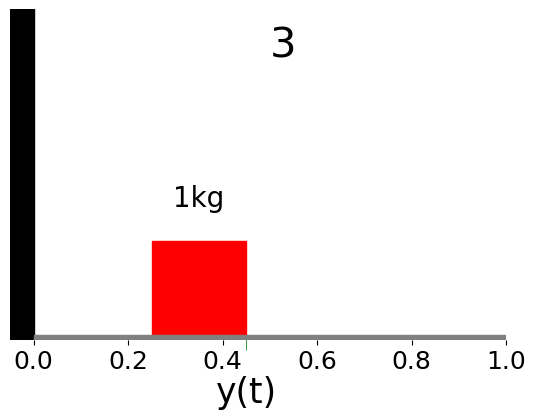

In [9]:
# %matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation

conf = CONF_0

fig = plt.figure()
ax = fig.add_subplot()

col_ani = create_animation(conf, ax, CollisionAnimation)
ani = animation.FuncAnimation(
    fig, 
    lambda frame: col_ani.update(), 
    frames=conf.frames,
    interval=ANIME_INTERVAL,
    cache_frame_data=False
)

from IPython.display import HTML
HTML(ani.to_html5_video())

## 以下youtube用の動画作成 (配位空間)

In [10]:
import math
import numpy as np


class ConfigurationAnimation(Animation):
    
    def __init__(self, ax, lobj: Obj, sobj: Obj):
        self.ax = ax
        self.set_ax_config()
        self.simulator = FrameByFrameSimulator(lobj, sobj)
        self.do_coord_change = False

        scale_x, scale_y = self.get_scales()
        self.line_x = np.arange(
            0, 
            (FLOOR_WIDTH + 0.01) * scale_x,
            0.01 * scale_x
        )
        self.line_wall_collision = self.line_x * scale_y / scale_x
        self.line_obj_collision = \
            np.ones(self.line_x.shape) * (self.simulator.sobj.width)

    def set_coord_change(self, change: bool):
        self.do_coord_change = change

    def set_ax_config(self):
        self.ax.set_aspect('equal')
        self.ax.tick_params(
            #labelbottom=False, 
            #labelleft=False, 
            labelright=False, 
            labeltop=False, 
            bottom=False, 
            left=False, 
            right=False, 
            top=False
        )
        self.ax.spines['right'].set_visible(False)
        self.ax.spines['top'].set_visible(False)
        # self.ax.spines['bottom'].set_visible(False)
        # self.ax.spines['left'].set_visible(False)
        self.ax.tick_params(labelsize=18)

    def init_frame(self):
        self.ax.cla()
        scale_x, scale_y = self.get_scales()
        self.ax.set_xlim([0, FLOOR_WIDTH * scale_x])
        self.ax.set_ylim([0, (FLOOR_WIDTH - 0.2) * scale_y])

    def get_scales(self) -> Tuple[float, float]:
        return (
            math.sqrt(self.simulator.lobj.weight) if self.do_coord_change else 1,
            math.sqrt(self.simulator.sobj.weight) if self.do_coord_change else 1,
        )
        
    def draw_lines(self):
        self.ax.plot(
            self.line_x, 
            self.line_wall_collision, 
            "-", 
            color="gray"
        )

        self.ax.plot(
            self.line_x, 
            self.line_obj_collision, 
            ":", 
            color="gray"
        )

    def draw_point(self):
        scale_x, scale_y = self.get_scales()
        coord_x, coord_y = self.simulator.get_coord()
        self.ax.plot(
            scale_x * coord_x,
            scale_y * coord_y,
            marker='.',
            markersize=20,
            color="green"
        )

    def _draw_first_frame(self):
        # 見た目調整用
        self.init_frame()
        self.draw_lines()
        self.draw_point()

    def update(self):
        self.init_frame()
        
        self.simulator.next()
        
        self.draw_lines()
        self.draw_point()

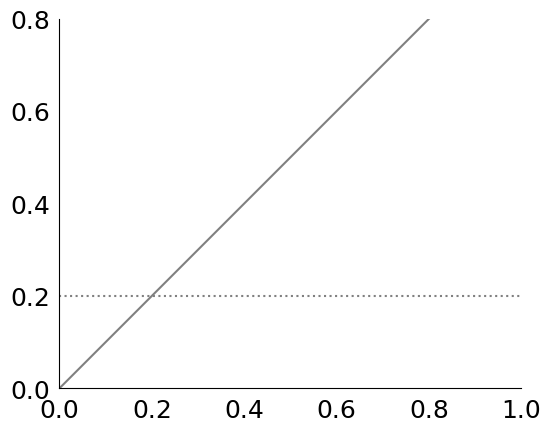

In [11]:
# %matplotlib notebook

_conf = CONF_0

_fig = plt.figure()
_ax = _fig.add_subplot()

conf_ani = create_animation(_conf, _ax, ConfigurationAnimation)
# conf_ani.set_coord_change(True)

_ani = animation.FuncAnimation(
    _fig, 
    lambda frame: conf_ani.update(), 
    frames=_conf.frames, 
    interval=ANIME_INTERVAL,
    cache_frame_data=False
)

HTML(_ani.to_html5_video())